In [196]:
import torch
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms
import numpy as np
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [197]:
dataset = pd.read_csv('/content/AirPassengers.csv')

In [198]:
dataset

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121
...,...,...
139,1960-08,606
140,1960-09,508
141,1960-10,461
142,1960-11,390


In [199]:
dataset.describe()

,#Passengers
count,144.000000
mean,280.298611
std,119.966317
min,104.000000
25%,180.000000
50%,265.500000
75%,360.500000
max,622.000000


In [200]:
#checking missing values
dataset.isnull().sum()

Month          0
#Passengers    0
dtype: int64

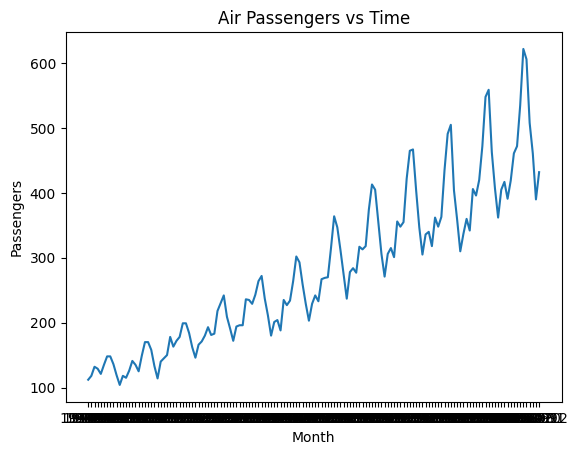

In [201]:
#trend
plt.plot(dataset["Month"], dataset["#Passengers"])
plt.xlabel("Month")
plt.ylabel("Passengers")
plt.title("Air Passengers vs Time")
plt.show()

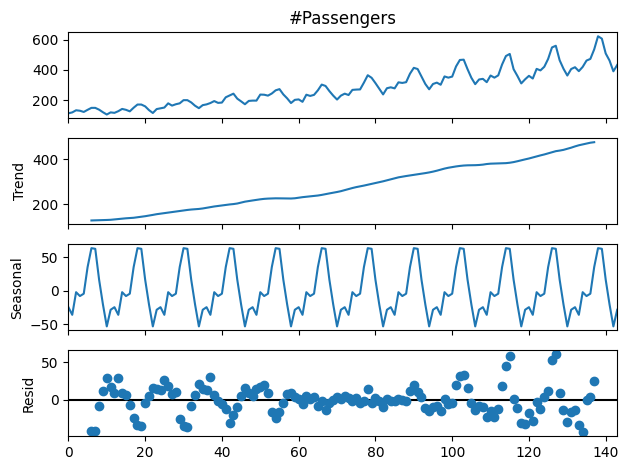

In [202]:
#seasonal decomposition
decomposition = seasonal_decompose(dataset["#Passengers"], model="additive", period=12)
decomposition.plot()
plt.show()

In [203]:
def create_sequences(data, look_back):
    X, y = [], []
    for i in range(look_back, len(data)):
        X.append(data[i-look_back:i])
        y.append(data[i])
    return np.array(X), np.array(y)

look_back = 12
X, y = create_sequences(dataset['#Passengers'].values, look_back)


In [204]:
#split into train,test,val
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.1, random_state=42)

#converting to PyTorch tensors
X_train_tensor = torch.tensor(X_train).view(-1, 1, 1).float()
y_train_tensor = torch.tensor(y_train).view(-1, 1, 1).float()
X_val_tensor = torch.tensor(X_val).view(-1, 1, 1).float()
y_val_tensor = torch.tensor(y_val).view(-1, 1, 1).float()
X_test_tensor = torch.tensor(X_test).view(-1, 1, 1).float()
y_test_tensor = torch.tensor(y_test).view(-1, 1, 1).float()

In [205]:
#LSTM model
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, activation=nn.ReLU()):
        super(LSTM,self).__init__()
        self.lstm=nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc=nn.Linear(hidden_dim,1)
        self.activation=activation

    def forward(self,x):
        out,(hn,cn)=self.lstm(x)
        out=self.activation(out)
        out=self.fc(out[:,-1,:])

        return out

In [206]:
input_dim = 1
hidden_dim = 256
num_layers = 2
learning_rate = 0.01
num_epochs = 100
batch_size = 32

In [207]:
model = LSTM(input_dim, hidden_dim, num_layers)

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.MSELoss()

In [208]:
#training
best_val_loss = float('inf')
epochs = 200
train_losses=[]
val_losses=[]

for epoch in range(epochs):
      model.train()
      optimizer.zero_grad()

      outputs=model(X_train_tensor)
      loss=criterion(outputs,y_train_tensor)

      loss.backward()
      optimizer.step()

      train_losses.append(loss.item())

      #validation
      model.eval()
      with torch.no_grad():
          val_outputs=model(X_val_tensor)
          val_loss=criterion(val_outputs,y_val_tensor)

      val_losses.append(val_loss.item())

      #overfitting check
      if val_loss < best_val_loss:
          best_val_loss = val_loss
          torch.save(model.state_dict(), 'best_model.pth')
      else:
          print(f'Early stopping at epoch {epoch+1} to prevent overfitting.')
          break

      if (epoch + 1) % 10 == 0:
          print(f'Epoch [{epoch+1}/{epochs}], Training Loss: {loss.item():.3f}, Validation Loss: {val_loss.item():.3f}')


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([105, 1, 1])) that is different to the input size (torch.Size([1260, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([24, 1, 1])) that is different to the input size (torch.Size([288, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [10/200], Training Loss: 97482.898, Validation Loss: 91251.594
Epoch [20/200], Training Loss: 92572.961, Validation Loss: 86489.844
Epoch [30/200], Training Loss: 87667.750, Validation Loss: 81756.086
Epoch [40/200], Training Loss: 82962.883, Validation Loss: 77230.406
Epoch [50/200], Training Loss: 78504.617, Validation Loss: 72948.961
Epoch [60/200], Training Loss: 74291.180, Validation Loss: 68907.844
Epoch [70/200], Training Loss: 70310.141, Validation Loss: 65094.344
Epoch [80/200], Training Loss: 66547.898, Validation Loss: 61495.129
Epoch [90/200], Training Loss: 62992.062, Validation Loss: 58098.043
Epoch [100/200], Training Loss: 59631.750, Validation Loss: 54892.535
Epoch [110/200], Training Loss: 56457.414, Validation Loss: 51869.168
Epoch [120/200], Training Loss: 53460.359, Validation Loss: 49019.395
Epoch [130/200], Training Loss: 50632.656, Validation Loss: 46335.402
Epoch [140/200], Training Loss: 47966.895, Validation Loss: 43809.832
Epoch [150/200], Training Los

In [209]:
#loading best model
model.load_state_dict(torch.load('best_model.pth'))

#evaluating
model.eval()
with torch.no_grad():
    test_outputs = model(X_test_tensor)
    test_loss = criterion(test_outputs, y_test_tensor)

print(f'Test Loss: {test_loss.item():.3f}')

Test Loss: 5474.978


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([3, 1, 1])) that is different to the input size (torch.Size([36, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


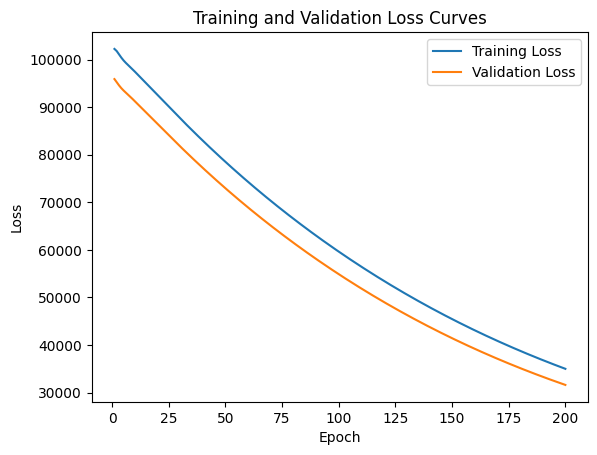

In [210]:
# Plot both training and validation loss curves
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Curves')
plt.legend()
plt.show()

In [211]:
#converting predictions and actual values back to numpy arrays
y_pred = test_outputs.numpy()
y_true = y_test_tensor.numpy()

In [212]:
#MSE, RMSE, and MAPE
def calculate_mse(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)

def calculate_rmse(y_true, y_pred):
    mse = np.mean((y_true - y_pred) ** 2)
    return np.sqrt(mse)

def calculate_mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [213]:
#evaluation metrics
mse = calculate_mse(y_true, y_pred)
rmse = calculate_rmse(y_true, y_pred)
mape = calculate_mape(y_true, y_pred)

print(f'Mean Squared Error(MSE): {mse:.3f}')
print(f'Root Mean Squared Error(RMSE): {rmse:.3f}')
print(f'Mean Absolute Percentage Error(MAPE): {mape:.3f}%')


Mean Squared Error(MSE): 5474.978
Root Mean Squared Error(RMSE): 73.993
Mean Absolute Percentage Error(MAPE): 28.859%
